In [1]:
import soundfile as sf
import numpy as np
import librosa
import glob
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [8, 4]

In [2]:
df = pd.read_csv('./Data/data_labeled.tsv', sep='\t')
display(df.head())

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,label
0,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687170.mp3,He associated with the Formists.,2,1,fifties,female,us,3
1,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687171.mp3,"The ""ultra accelerator"" injection gives Derric...",2,1,fifties,female,us,3
2,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687172.mp3,"Despite running as a joke, candidates have won...",2,0,fifties,female,us,3
3,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687173.mp3,Stoner also guest-starred in the television dr...,2,0,fifties,female,us,3
4,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687174.mp3,Rainelle was named for the Raine family.,2,0,fifties,female,us,3


In [3]:
def eda(df, row_limit=5, list_elements_limit=10):
    print('Info: There are {} rows and {} columns in the dataset'.format(df.shape[0], df.shape[1]))
    print('\n')

    dtypes_df = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_df = dtypes_df[dtypes_df['dtype']=='object']
    num_df = dtypes_df[dtypes_df['dtype']!='object']

    print('There are {} categorical columns'.format(len(cat_df)))
    print('There are {} numerical columns'.format(len(num_df)))
    print('\n')
    if list_elements_limit >= len(cat_df):
        print('The categorical columns are: {}'.format(list(cat_df['column_name'])))
    else:
        print('The categorical columns are: {}'.format(list(cat_df['column_name'])[:list_elements_limit]))
    
    if list_elements_limit >= len(num_df):
        print('The numerical columns are: {}'.format(list(num_df['column_name'])))
    else:
        print('The numerical columns are: {}'.format(list(num_df['column_name'])[:list_elements_limit]))

    display(dtypes_df.head(row_limit))

    print('\n')

    desc_df_cat = df[cat_df['column_name']].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_cat.head(row_limit))

    print('\n')
    print('Null Values in the dataset')
    print(df.isnull().sum())

    return

In [4]:
eda(df, row_limit=10, list_elements_limit=10)

Info: There are 209791 rows and 9 columns in the dataset


There are 6 categorical columns
There are 3 numerical columns


The categorical columns are: ['client_id', 'path', 'sentence', 'age', 'gender', 'accent']
The numerical columns are: ['up_votes', 'down_votes', 'label']


,column_name,dtype
0,client_id,object
1,path,object
2,sentence,object
3,up_votes,int64
4,down_votes,int64
5,age,object
6,gender,object
7,accent,object
8,label,int64


,column_name,count,unique,top,freq
0,client_id,209791,5656,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,8252
1,path,209791,209791,common_voice_en_19499081.mp3,1
2,sentence,209791,99541,"If you start your emails with ""Greetings"" let ...",48
3,age,209791,2,twenties,168343
4,gender,209791,2,male,165983
5,accent,153547,17,us,75940




Null Values in the dataset
client_id         0
path              0
sentence          0
up_votes          0
down_votes        0
age               0
gender            0
accent        56244
label             0
dtype: int64


In [5]:
LE_age = LabelEncoder()
df['age'] = LE_age.fit_transform(df['age'])

LE_gender = LabelEncoder()
df['gender'] = LE_gender.fit_transform(df['gender'])

In [6]:
print(LE_age.classes_)

['fifties' 'twenties']


In [7]:
print(LE_gender.classes_)

['female' 'male']


In [15]:
import os
import pandas as pd
from pathlib import Path

def filter_valid_audio_files(df):
    valid_rows = []
    base_folder = Path('./Data/Audio/')
    for idx, row in df.iterrows():
        file_path = base_folder / row['path']

        try:
            # Check if file exists and can be loaded
            if os.path.exists(file_path):
                librosa.load(file_path, sr=None)

                # Extract folder name from the path as the source
                source_folder = os.path.basename(os.path.dirname(file_path))
                row_copy = row.copy()
                row_copy['source'] = source_folder

                valid_rows.append(row_copy)
            else:
                print(f"File not found: {file_path}")

        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    return pd.DataFrame(valid_rows)


In [10]:
import zipfile
import os
from pathlib import Path

def extract_and_remove_zip_files(folder_path):
    folder = Path(folder_path)

    for zip_path in folder.glob("*.zip"):
        print(f"Extracting: {zip_path.name}")
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(folder)  # Extract into the same directory

            zip_path.unlink()  # Delete the zip file after extraction
            print(f"✅ Extracted and deleted: {zip_path.name}")

        except Exception as e:
            print(f"❌ Failed to extract {zip_path.name}: {e}")
            continue

extract_and_remove_zip_files("./Data/Audio/")

Extracting: audio_batch_1.zip
✅ Extracted and deleted: audio_batch_1.zip
Extracting: audio_batch_10.zip
✅ Extracted and deleted: audio_batch_10.zip
Extracting: audio_batch_11.zip
✅ Extracted and deleted: audio_batch_11.zip
Extracting: audio_batch_12.zip
✅ Extracted and deleted: audio_batch_12.zip
Extracting: audio_batch_13.zip
✅ Extracted and deleted: audio_batch_13.zip
Extracting: audio_batch_14.zip
✅ Extracted and deleted: audio_batch_14.zip
Extracting: audio_batch_15.zip
✅ Extracted and deleted: audio_batch_15.zip
Extracting: audio_batch_16.zip
✅ Extracted and deleted: audio_batch_16.zip
Extracting: audio_batch_17.zip
✅ Extracted and deleted: audio_batch_17.zip
Extracting: audio_batch_18.zip
✅ Extracted and deleted: audio_batch_18.zip
Extracting: audio_batch_19.zip
✅ Extracted and deleted: audio_batch_19.zip
Extracting: audio_batch_2.zip
✅ Extracted and deleted: audio_batch_2.zip
Extracting: audio_batch_20.zip
✅ Extracted and deleted: audio_batch_20.zip
Extracting: audio_batch_3.zip

In [16]:
filtered_df = filter_valid_audio_files(df)

Error loading Data\Audio\common_voice_en_529569.mp3: 
Error loading Data\Audio\common_voice_en_529573.mp3: 
Error loading Data\Audio\common_voice_en_570619.mp3: 
Error loading Data\Audio\common_voice_en_570621.mp3: 
Error loading Data\Audio\common_voice_en_570622.mp3: 
Error loading Data\Audio\common_voice_en_570623.mp3: 
Error loading Data\Audio\common_voice_en_508243.mp3: 
Error loading Data\Audio\common_voice_en_54973.mp3: 
Error loading Data\Audio\common_voice_en_82281.mp3: 
Error loading Data\Audio\common_voice_en_541573.mp3: 
Error loading Data\Audio\common_voice_en_84713.mp3: 
Error loading Data\Audio\common_voice_en_589235.mp3: 
Error loading Data\Audio\common_voice_en_589236.mp3: 
Error loading Data\Audio\common_voice_en_589238.mp3: 
Error loading Data\Audio\common_voice_en_589239.mp3: 
Error loading Data\Audio\common_voice_en_589240.mp3: 
Error loading Data\Audio\common_voice_en_453064.mp3: 
Error loading Data\Audio\common_voice_en_57832.mp3: 
Error loading Data\Audio\common_

In [19]:
filtered_df.to_csv('./Data/data_labeled_filtered.csv', index=False)

In [20]:
display(filtered_df.head(10))

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,label,source
0,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687170.mp3,He associated with the Formists.,2,1,0,0,us,3,Audio
1,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687171.mp3,"The ""ultra accelerator"" injection gives Derric...",2,1,0,0,us,3,Audio
2,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687172.mp3,"Despite running as a joke, candidates have won...",2,0,0,0,us,3,Audio
3,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687173.mp3,Stoner also guest-starred in the television dr...,2,0,0,0,us,3,Audio
4,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687174.mp3,Rainelle was named for the Raine family.,2,0,0,0,us,3,Audio
7,509994614d284ab2b1415df149ac1bdb05fef1adf8d33f...,common_voice_en_18421093.mp3,He is a climate change sceptic. Good grief!,2,1,1,1,us,0,Audio
8,509994614d284ab2b1415df149ac1bdb05fef1adf8d33f...,common_voice_en_18421094.mp3,The director wasn't happy with the change.,2,0,1,1,us,0,Audio
9,509994614d284ab2b1415df149ac1bdb05fef1adf8d33f...,common_voice_en_18421095.mp3,The roof has been patched up many times over t...,2,0,1,1,us,0,Audio
10,509994614d284ab2b1415df149ac1bdb05fef1adf8d33f...,common_voice_en_18421096.mp3,Building your house on sand is not recommended.,2,0,1,1,us,0,Audio
11,509994614d284ab2b1415df149ac1bdb05fef1adf8d33f...,common_voice_en_18421097.mp3,"Catherine, contented at first, in a brief spac...",2,0,1,1,us,0,Audio


In [25]:
import zipfile
import os
from pathlib import Path
from tqdm import tqdm

# Create output directory if it doesn't exist
output_dir = Path('./Data/processed_audio')
output_dir.mkdir(exist_ok=True)

# Path for the zip file
zip_path = output_dir / 'all_audio_files.zip'

# Get base directory for audio files
base_dir = Path('./Data/Audio')

# Create a counter for found and missing files
found_files = 0
missing_files = 0

# Create the zip file
with zipfile.ZipFile(zip_path, 'w') as zipf:
    # Loop through DataFrame rows with progress bar
    for idx, row in tqdm(filtered_df.iterrows(), total=len(filtered_df), desc="Zipping audio files"):
        # Get the file path
        file_path = base_dir / row['path']
        
        # Check if file exists
        if os.path.exists(file_path):
            # Add to zip file
            zipf.write(file_path, arcname=os.path.basename(file_path))
            found_files += 1
        else:
            missing_files += 1
            if missing_files <= 10:  # Limit the number of missing file messages
                print(f"Warning: File not found: {file_path}")
            elif missing_files == 11:
                print("Too many missing files, suppressing further warnings...")

print(f"Zipping complete: {found_files} files added to {zip_path}")
print(f"Missing files: {missing_files}")

Zipping audio files: 100%|██████████| 172158/172158 [27:57<00:00, 102.64it/s]


Zipping complete: 172158 files added to Data\processed_audio\all_audio_files.zip
Missing files: 0


In [ ]:
filtered_df.drop(columns=['client_id'], inplace=True)

eda(filtered_df, row_limit=10, list_elements_limit=10)

KeyError: "['client_id'] not found in axis"

In [24]:
filtered_df.to_csv('./Data/data_labeled_filtered.csv', index=False)

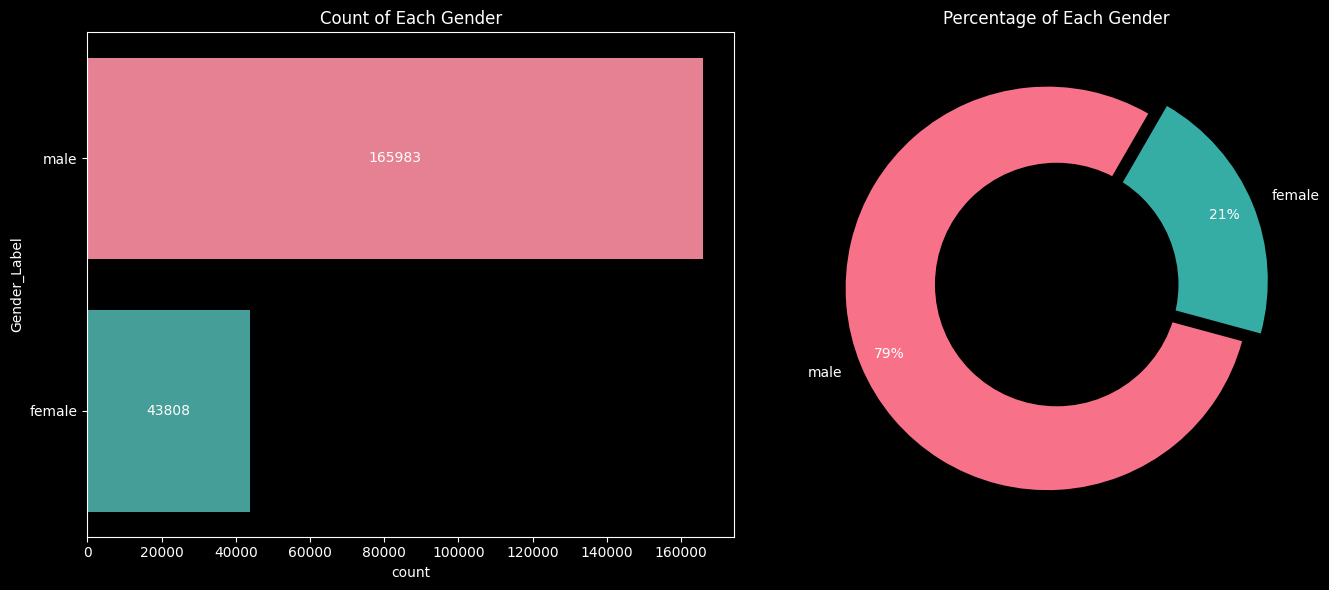

In [ ]:
df['Gender_Label'] = LE_gender.inverse_transform(df['gender'])

gender_counts = df['Gender_Label'].value_counts()
gender_labels = gender_counts.index
gender_sizes = gender_counts.values

gender_colors = sns.color_palette("husl", n_colors=len(gender_counts))
gender_color_map = dict(zip(gender_labels, gender_colors))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(y=df['Gender_Label'], order=gender_labels, palette=gender_color_map, ax=axes[0])
axes[0].set_title("Count of Each Gender", color='white')
axes[0].tick_params(axis='both', colors='white')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', label_type='center', color='white')

explode = [0.05] * len(gender_sizes)
axes[1].pie(
    gender_sizes,
    labels=gender_labels,
    colors=[gender_color_map[label] for label in gender_labels],
    explode=explode,
    startangle=60,
    autopct='%1.0f%%',
    pctdistance=0.85,
    textprops={'color': 'white'}
)
axes[1].add_artist(plt.Circle((0, 0), 0.6, color='black'))
axes[1].set_title("Percentage of Each Gender", color='white')

plt.tight_layout()
plt.show()


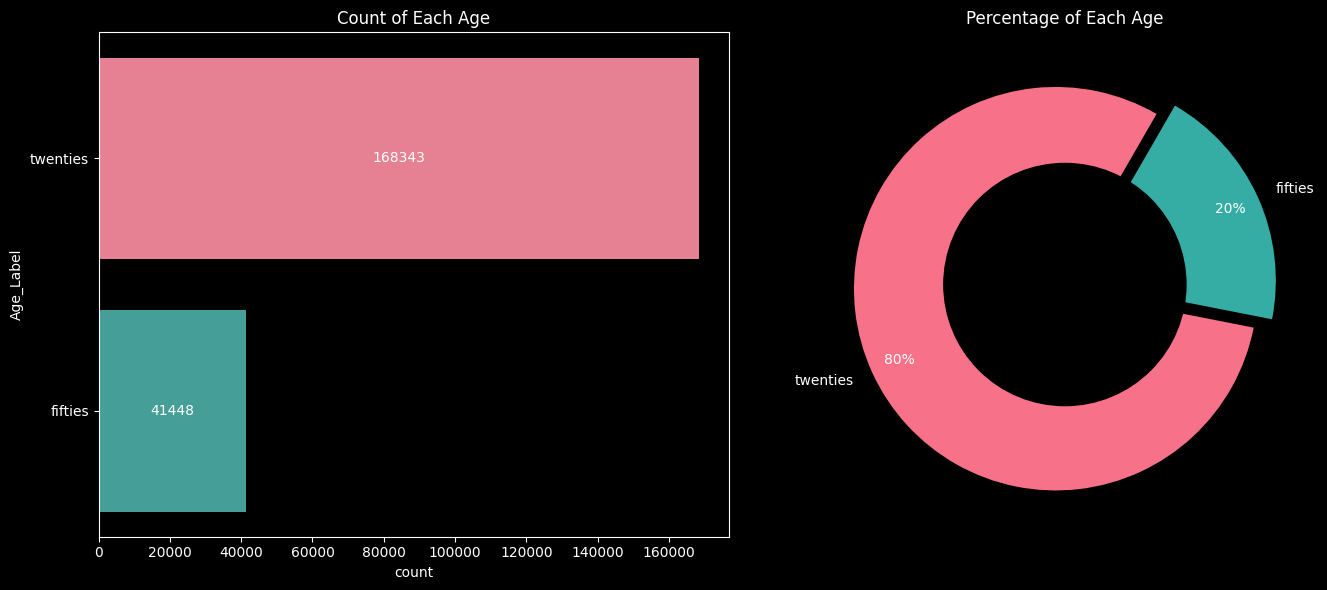

In [ ]:
df['Age_Label'] = LE_age.inverse_transform(df['age'])

age_counts = df['Age_Label'].value_counts()
age_labels = age_counts.index
age_sizes = age_counts.values

age_colors = sns.color_palette("husl", n_colors=len(age_counts))
age_color_map = dict(zip(age_labels, age_colors))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(y=df['Age_Label'], order=age_labels, palette=age_color_map, ax=axes[0])
axes[0].set_title("Count of Each Age", color='white')
axes[0].tick_params(axis='both', colors='white')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', label_type='center', color='white')

explode = [0.05] * len(age_sizes)
axes[1].pie(
    age_sizes,
    labels=age_labels,
    colors=[age_color_map[label] for label in age_labels],
    explode=explode,
    startangle=60,
    autopct='%1.0f%%',
    pctdistance=0.85,
    textprops={'color': 'white'}
)
axes[1].add_artist(plt.Circle((0, 0), 0.6, color='black'))
axes[1].set_title("Percentage of Each Age", color='white')

plt.tight_layout()
plt.show()


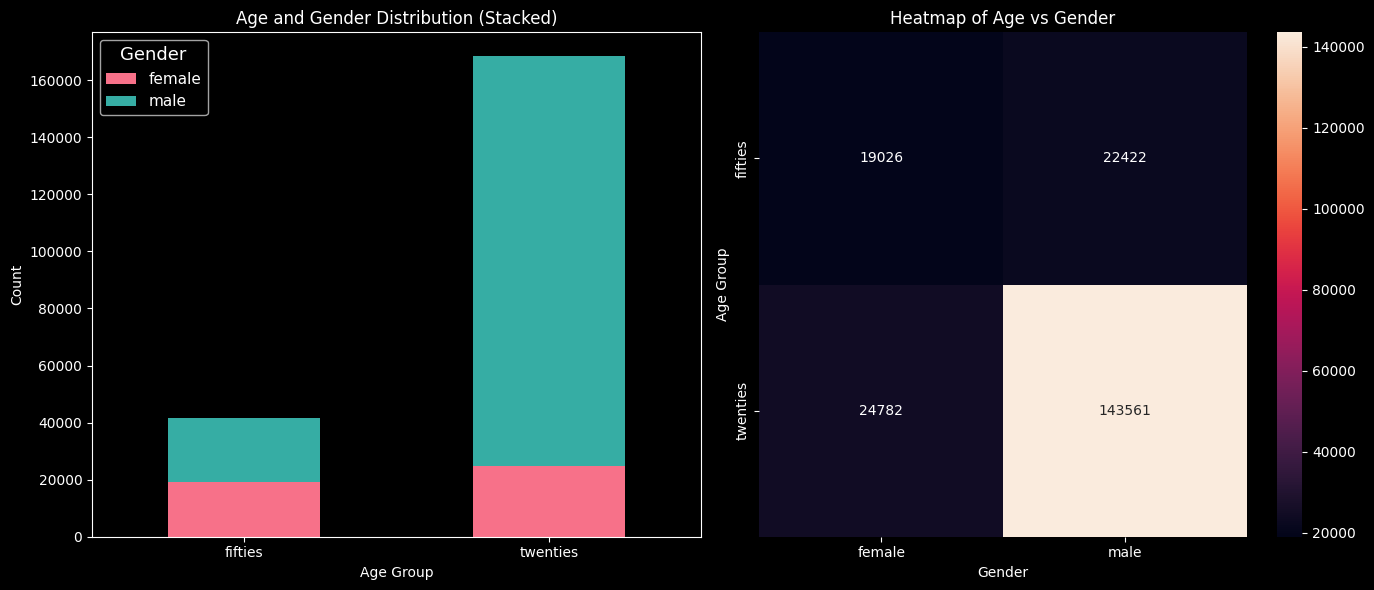

In [ ]:
df['Age_Label'] = LE_age.inverse_transform(df['age'])
df['Gender_Label'] = LE_gender.inverse_transform(df['gender'])

age_gender_counts = df.groupby(['Age_Label', 'Gender_Label']).size().unstack().fillna(0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

age_gender_counts.plot(
    kind='bar',
    stacked=True,
    color=sns.color_palette('husl', 2),
    ax=axes[0]
)
axes[0].set_title("Age and Gender Distribution (Stacked)", color='white')
axes[0].set_xlabel("Age Group", color='white')
axes[0].set_ylabel("Count", color='white')
axes[0].tick_params(axis='x', rotation=0, colors='white')
axes[0].tick_params(axis='y', colors='white')
axes[0].legend(title='Gender', facecolor='black', labelcolor='white', title_fontsize='13', fontsize='11')

sns.heatmap(age_gender_counts, annot=True, fmt='d', ax=axes[1])
axes[1].set_title("Heatmap of Age vs Gender", color='white')
axes[1].set_xlabel("Gender", color='white')
axes[1].set_ylabel("Age Group", color='white')
axes[1].tick_params(axis='x', colors='white')
axes[1].tick_params(axis='y', colors='white')

plt.tight_layout()
plt.show()

### Exploring Audio Batch 1

In [ ]:
audio_files = glob.glob('./Data/audio_batch_1/*.mp3')
data = []

for file in tqdm(audio_files, desc="Processing audio files"):
    basename = os.path.basename(file)

    matching_row = df[df['path'].str.contains(basename, na=False)]
    
    if not matching_row.empty:
        row = matching_row.iloc[0]
        data.append({
            'path': file,
            'age': row['Age_Label'],
            'gender': row['Gender_Label']
        })

audio_df = pd.DataFrame(data)

# Display the result
print(f"Found {len(audio_df)} matching audio files")
display(audio_df.head())

Processing audio files: 100%|██████████| 10490/10490 [11:17<00:00, 15.49it/s]

Found 10490 matching audio files


,path,age,gender
0,./Data/audio_batch_1\common_voice_en_100306.mp3,twenties,male
1,./Data/audio_batch_1\common_voice_en_100324.mp3,twenties,male
2,./Data/audio_batch_1\common_voice_en_100325.mp3,twenties,male
3,./Data/audio_batch_1\common_voice_en_100340.mp3,twenties,male
4,./Data/audio_batch_1\common_voice_en_100403.mp3,twenties,male


In [ ]:
audio_df['age'] = LE_age.transform(audio_df['age'])
audio_df['gender'] = LE_gender.transform(audio_df['gender'])

display(audio_df.head())

,path,age,gender,Age_Label,Gender_Label
0,./Data/audio_batch_1\common_voice_en_100306.mp3,1,1,1,1
1,./Data/audio_batch_1\common_voice_en_100324.mp3,1,1,1,1
2,./Data/audio_batch_1\common_voice_en_100325.mp3,1,1,1,1
3,./Data/audio_batch_1\common_voice_en_100340.mp3,1,1,1,1
4,./Data/audio_batch_1\common_voice_en_100403.mp3,1,1,1,1


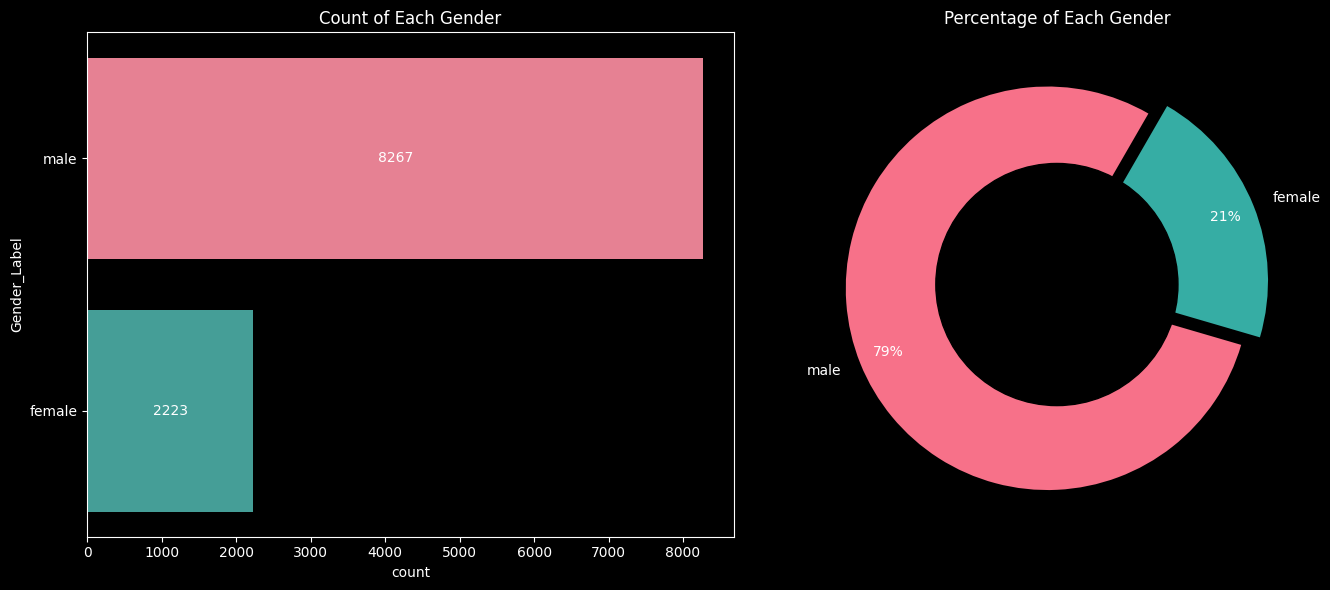

In [ ]:
audio_df['Gender_Label'] = LE_gender.inverse_transform(audio_df['gender'])

gender_counts = audio_df['Gender_Label'].value_counts()
gender_labels = gender_counts.index
gender_sizes = gender_counts.values

gender_colors = sns.color_palette("husl", n_colors=len(gender_counts))
gender_color_map = dict(zip(gender_labels, gender_colors))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(y=audio_df['Gender_Label'], order=gender_labels, palette=gender_color_map, ax=axes[0])
axes[0].set_title("Count of Each Gender", color='white')
axes[0].tick_params(axis='both', colors='white')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', label_type='center', color='white')

explode = [0.05] * len(gender_sizes)
axes[1].pie(
    gender_sizes,
    labels=gender_labels,
    colors=[gender_color_map[label] for label in gender_labels],
    explode=explode,
    startangle=60,
    autopct='%1.0f%%',
    pctdistance=0.85,
    textprops={'color': 'white'}
)
axes[1].add_artist(plt.Circle((0, 0), 0.6, color='black'))
axes[1].set_title("Percentage of Each Gender", color='white')

plt.tight_layout()
plt.show()


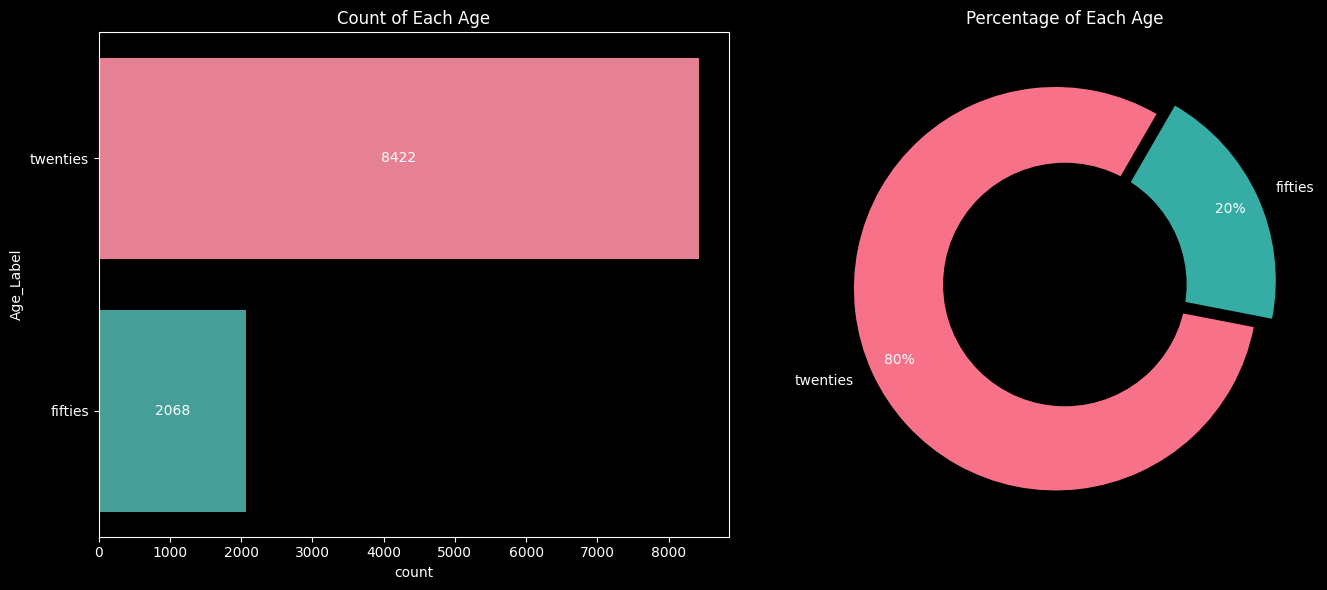

In [ ]:
audio_df['Age_Label'] = LE_age.inverse_transform(audio_df['age'])

age_counts = audio_df['Age_Label'].value_counts()
age_labels = age_counts.index
age_sizes = age_counts.values

age_colors = sns.color_palette("husl", n_colors=len(age_counts))
age_color_map = dict(zip(age_labels, age_colors))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(y=audio_df['Age_Label'], order=age_labels, palette=age_color_map, ax=axes[0])
axes[0].set_title("Count of Each Age", color='white')
axes[0].tick_params(axis='both', colors='white')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', label_type='center', color='white')

explode = [0.05] * len(age_sizes)
axes[1].pie(
    age_sizes,
    labels=age_labels,
    colors=[age_color_map[label] for label in age_labels],
    explode=explode,
    startangle=60,
    autopct='%1.0f%%',
    pctdistance=0.85,
    textprops={'color': 'white'}
)
axes[1].add_artist(plt.Circle((0, 0), 0.6, color='black'))
axes[1].set_title("Percentage of Each Age", color='white')

plt.tight_layout()
plt.show()


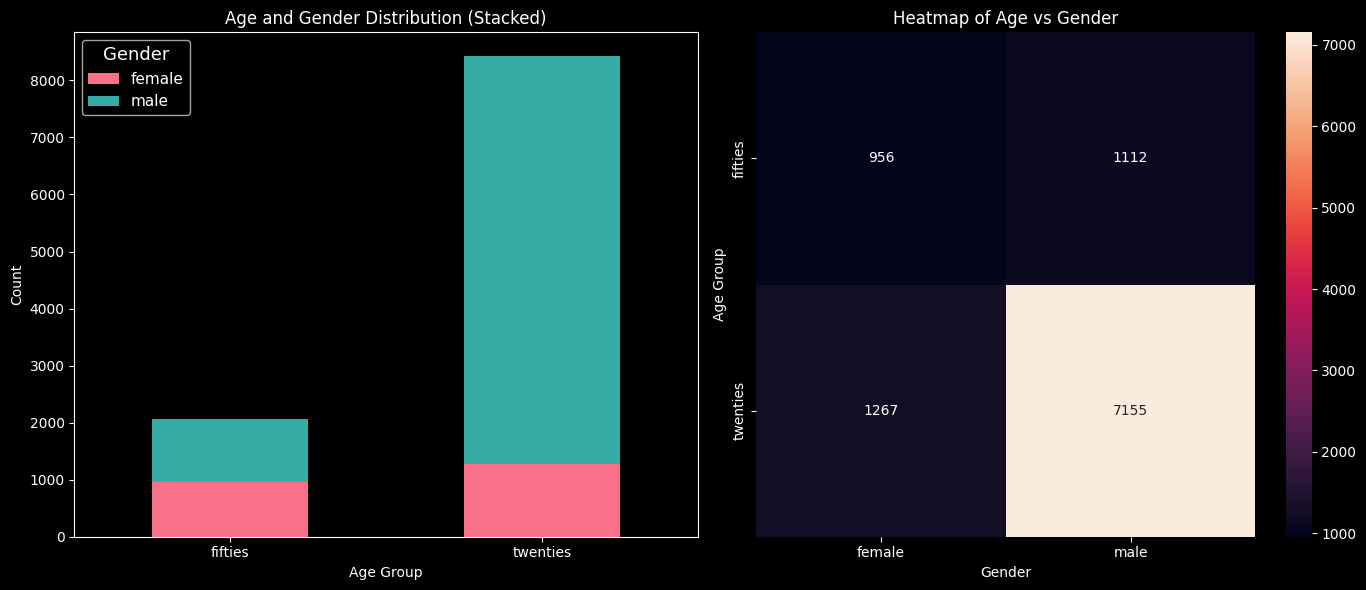

In [ ]:
audio_df['Age_Label'] = LE_age.inverse_transform(audio_df['age'])
audio_df['Gender_Label'] = LE_gender.inverse_transform(audio_df['gender'])

age_gender_counts = audio_df.groupby(['Age_Label', 'Gender_Label']).size().unstack().fillna(0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

age_gender_counts.plot(
    kind='bar',
    stacked=True,
    color=sns.color_palette('husl', 2),
    ax=axes[0]
)
axes[0].set_title("Age and Gender Distribution (Stacked)", color='white')
axes[0].set_xlabel("Age Group", color='white')
axes[0].set_ylabel("Count", color='white')
axes[0].tick_params(axis='x', rotation=0, colors='white')
axes[0].tick_params(axis='y', colors='white')
axes[0].legend(title='Gender', facecolor='black', labelcolor='white', title_fontsize='13', fontsize='11')

sns.heatmap(age_gender_counts, annot=True, fmt='d', ax=axes[1])
axes[1].set_title("Heatmap of Age vs Gender", color='white')
axes[1].set_xlabel("Gender", color='white')
axes[1].set_ylabel("Age Group", color='white')
axes[1].tick_params(axis='x', colors='white')
axes[1].tick_params(axis='y', colors='white')

plt.tight_layout()
plt.show()

Male, twenties: 7155
Female, twenties: 1267
Male, fifties: 1112
Female, fifties: 956

Balanced dataset statistics:
Total samples: 3956
Gender_Label  Age_Label
female        fifties       956
              twenties     1000
male          fifties      1000
              twenties     1000
dtype: int64


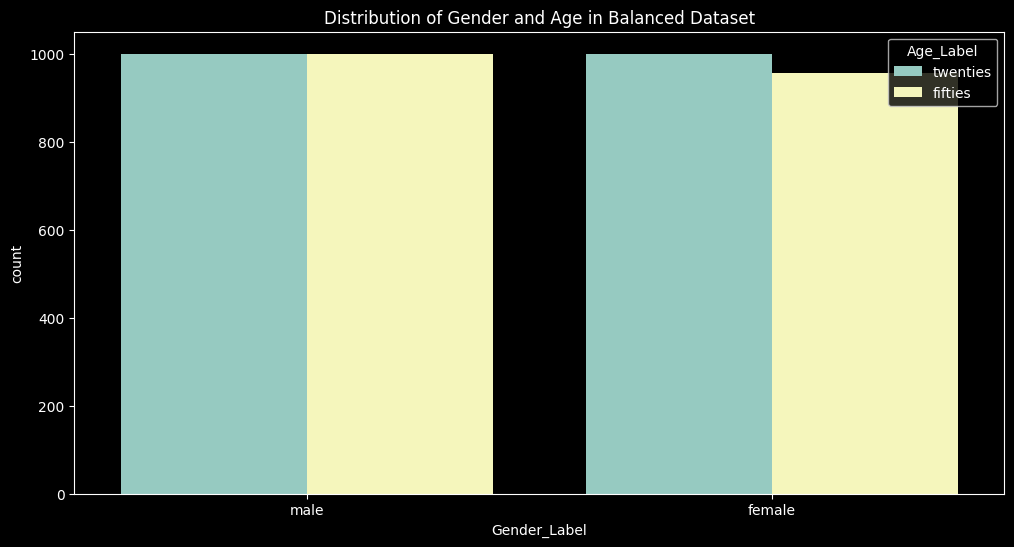

In [ ]:
male_twenties = audio_df[(audio_df['Gender_Label'] == 'male') & (audio_df['Age_Label'] == 'twenties')]
female_twenties = audio_df[(audio_df['Gender_Label'] == 'female') & (audio_df['Age_Label'] == 'twenties')]
male_fifties = audio_df[(audio_df['Gender_Label'] == 'male') & (audio_df['Age_Label'] == 'fifties')]
female_fifties = audio_df[(audio_df['Gender_Label'] == 'female') & (audio_df['Age_Label'] == 'fifties')]

print(f"Male, twenties: {len(male_twenties)}")
print(f"Female, twenties: {len(female_twenties)}")
print(f"Male, fifties: {len(male_fifties)}")
print(f"Female, fifties: {len(female_fifties)}")

sample_size = 1000
male_twenties_sample = male_twenties.sample(sample_size, random_state=42)
female_twenties_sample = female_twenties.sample(min(sample_size, len(female_twenties)), random_state=42)
male_fifties_sample = male_fifties.sample(min(sample_size, len(male_fifties)), random_state=42)
female_fifties_sample = female_fifties.sample(min(sample_size, len(female_fifties)), random_state=42)

balanced_audio_df = pd.concat([male_twenties_sample, female_twenties_sample, 
                              male_fifties_sample, female_fifties_sample])

balanced_audio_df = balanced_audio_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nBalanced dataset statistics:")
print(f"Total samples: {len(balanced_audio_df)}")
print(balanced_audio_df.groupby(['Gender_Label', 'Age_Label']).size())

plt.figure(figsize=(12, 6))
sns.countplot(x='Gender_Label', hue='Age_Label', data=balanced_audio_df)
plt.title('Distribution of Gender and Age in Balanced Dataset')
plt.show()

In [ ]:
display(balanced_audio_df.head())

,path,age,gender,Age_Label,Gender_Label
0,./Data/audio_batch_1\common_voice_en_520047.mp3,1,1,twenties,male
1,./Data/audio_batch_1\common_voice_en_477389.mp3,1,0,twenties,female
2,./Data/audio_batch_1\common_voice_en_685541.mp3,1,0,twenties,female
3,./Data/audio_batch_1\common_voice_en_597969.mp3,1,1,twenties,male
4,./Data/audio_batch_1\common_voice_en_19950564.mp3,1,1,twenties,male


In [ ]:
audio_df.to_csv('./Data/audio_df.csv', index=False)